# Exploratory Data Analysis <br>

Author: Jamie McQuire <br>
Date: 24/01/2020 <br>

* This is a supplementary exploratory data analysis for the project.
* The data used in this report is from Google's speech command dataset.
* [Link to the challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview/description)
* This report will show how the audio data can be represented in different ways, including the log-spectrogram transformation of the data which is used to train the machine learning algorithms.
* Note: This file was created to supplement the report and the actual pre-processing files were used to generate the data are included in the submission folder.

In [43]:
#import the libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from random import gauss
from scipy.io import wavfile
import csv
from scipy import signal
import scipy

In [44]:
#change the working directory to the Data directory
os.chdir("C:\\Users\\b9027741\\OneDrive - Newcastle University\\Masters\\Computer Science\\Machine_Learning_Project\\Data")

# Raw Audio Files <br>

* This section of the report will read the audio files into the Python environment as time series vectors.
* The time series vectors will then be plotted as a signal.
* We can see that the different audio files have distinct shapes with the actual speech command occuring at different points in time.
* The silence audio file appears to represent a stationary process which is what we would expect with noise.
* We are not going to work with raw time series data and instead use a Discrete Fourier Transform (DFT) to plot the data as a spectrogram for image recognition.
* The image recognition networks could be used on the signal plots, however, more information could be extracted from the different frequency components present in the audio files.

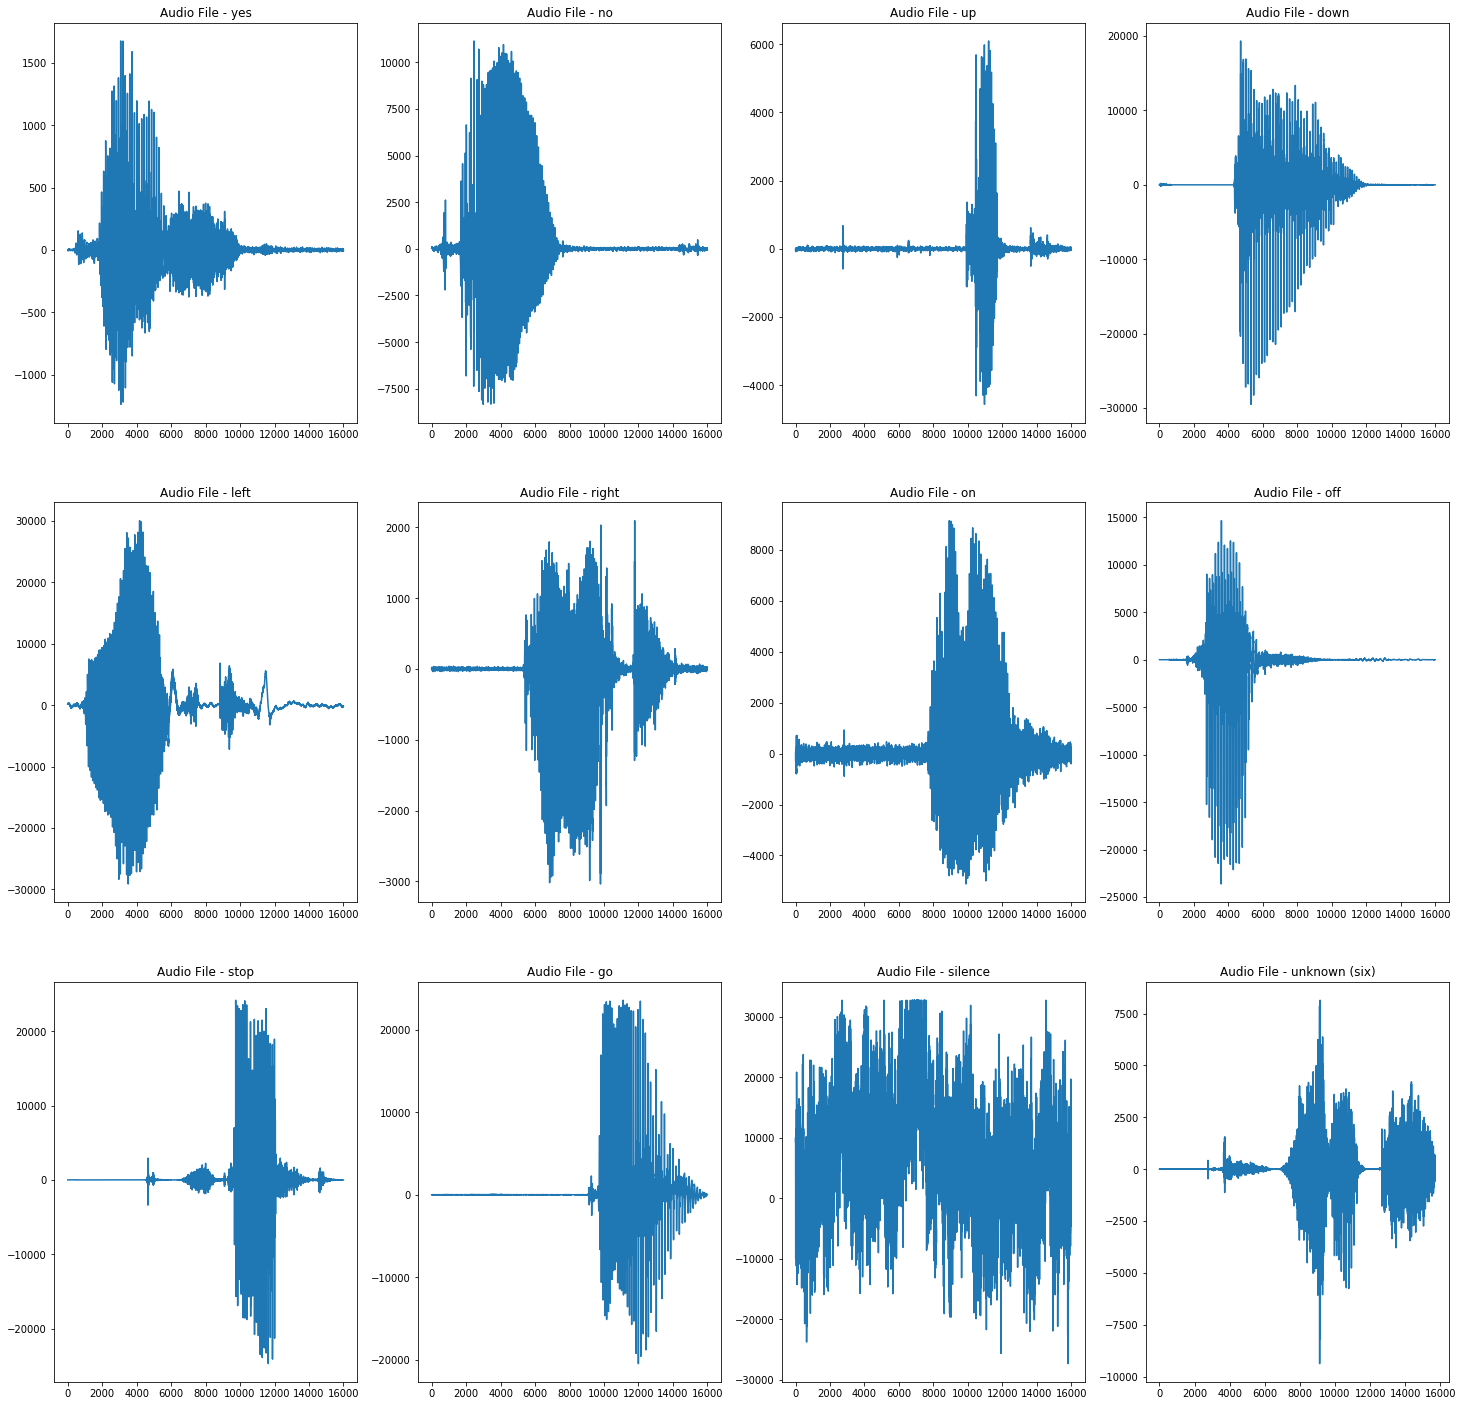

In [45]:
#picked 12 files to represent the full categories specified in the challenge
audio_list = ["yes/f2a90886_nohash_0.wav","no/e32ff49d_nohash_1.wav","up/d8ee4734_nohash_1.wav","down/cb8f8307_nohash_6.wav",
              "left/c1eebc0b_nohash_1.wav","right/b93528e3_nohash_0.wav", "on/a8688b67_nohash_0.wav", "off/96ab6565_nohash_2.wav",
             "stop/8eb4a1bf_nohash_0.wav","go/7cf14c54_nohash_0.wav","silence/noisy2_part57_pink_noise.wav","six/0b09edd3_nohash_2.wav"]

#create the labels for the audio_list
audio_labels = []
for x in audio_list:
    file_name = x.rsplit("/")[0]
    if file_name == "six":
        file_name = "unknown (six)"
    audio_labels.append(file_name)
    
fig,ax = plt.subplots(3,4,figsize=(25,25))

for i, audio in enumerate(audio_list):
    plt.subplot(3, 4, i+1)
    ax= plt.gca()
    ax.set_title("Audio File - " + audio_labels[i])
    sample_rate, audio = wavfile.read("train/audio/" + audio)
    ax.plot(audio)
    

# Fast Fourier Transform <br>

* This section of the report is going to translate the time series audio data into a representation of its frequency components.
* This will be achieved using a Discrete Fourier Transform (DFT) computed using the Fast Fourier Transform (FFT) algorithm.
* The DFT representation is going to be computed for the "yes", "no", and "up" voice commands, along with an audio file that contains silence.
* We can see that the audio files have frequency components with different amplitudes.
* This means that information about the frequencies could be used to differentitate between the different voice commands.

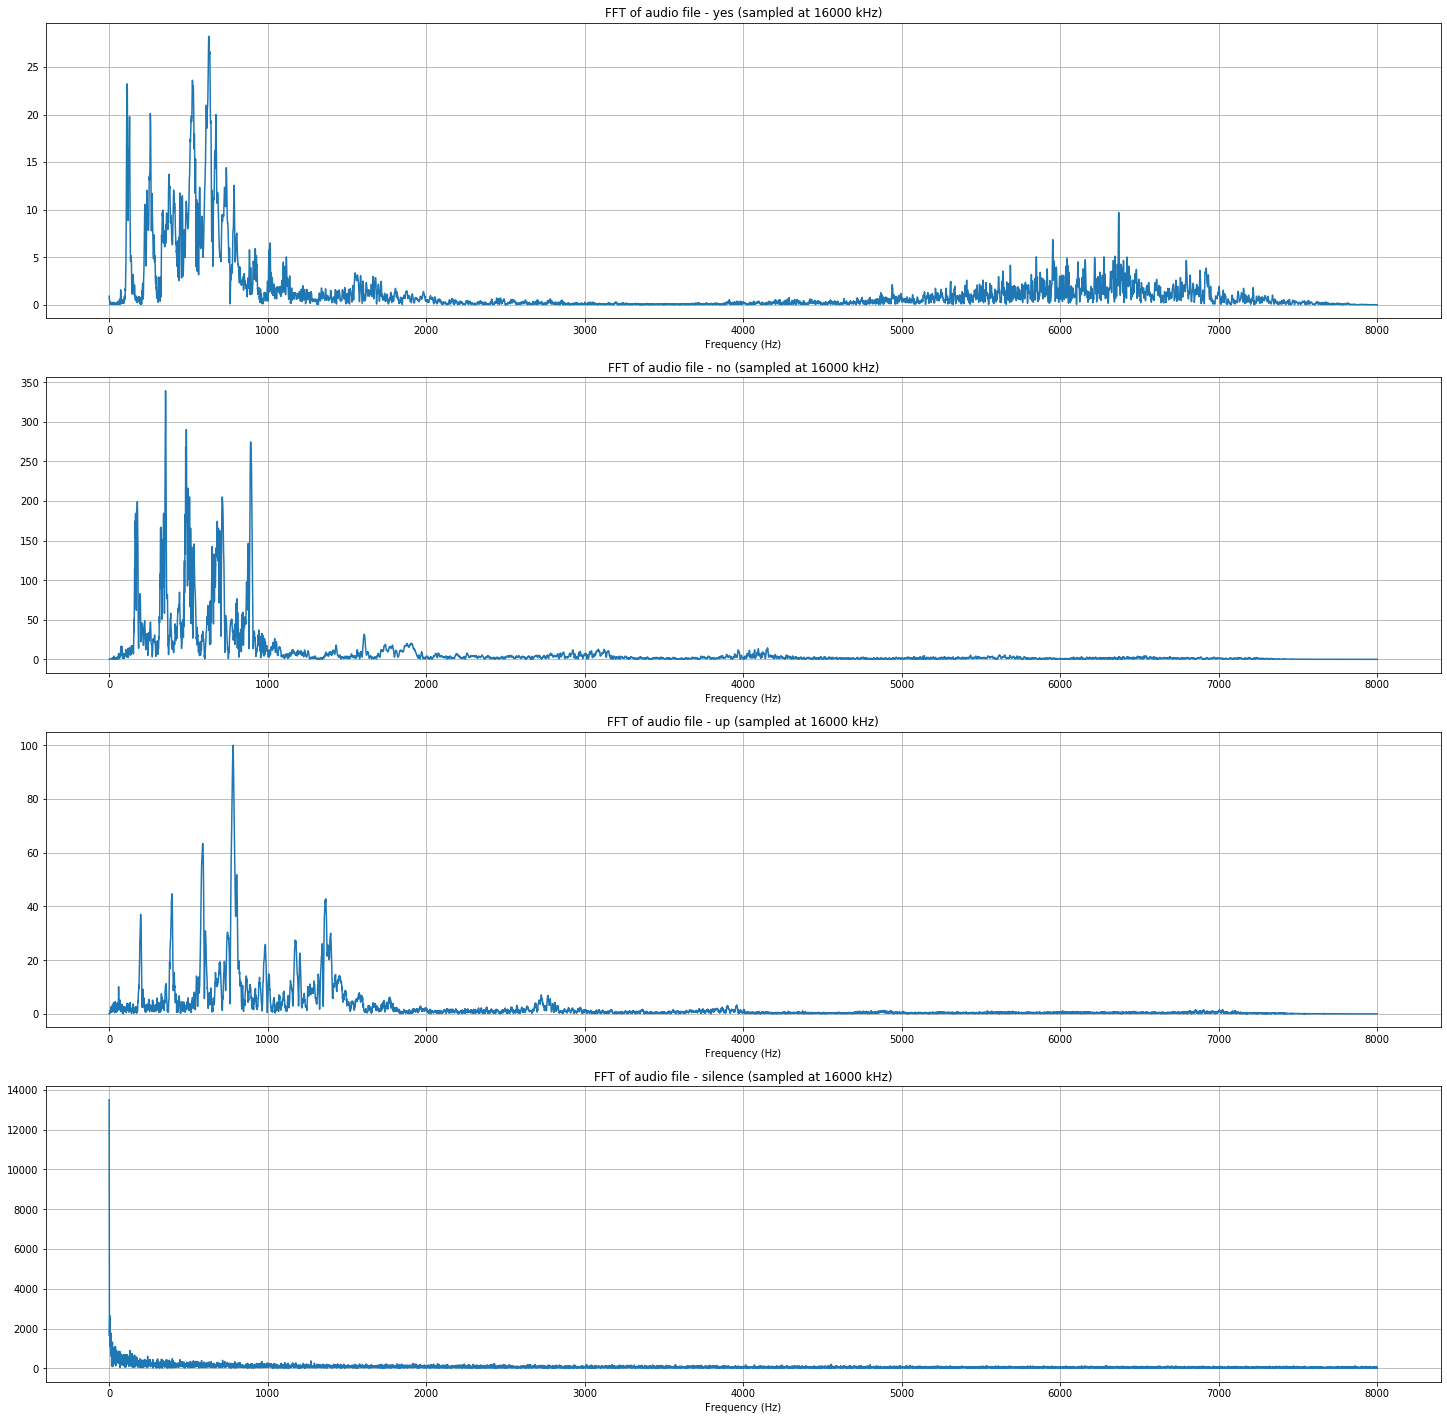

In [46]:
#list the files and the audio labels
audio_list = ["yes/f2a90886_nohash_0.wav","no/e32ff49d_nohash_1.wav","up/d8ee4734_nohash_1.wav","silence/noisy2_part57_pink_noise.wav"]
audio_labels = ["yes","no","up","silence"]

#fft function
def custom_fft(y, fs): #[1]
    T = 1.0 / fs
    N = y.shape[0]
    yf = scipy.fftpack.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2]) 
    return xf, vals

fig,ax = plt.subplots(4,1,figsize=(25,25))

#plot the ffts
for i, audio in enumerate(audio_list):
    plt.subplot(4, 1, i+1)
    ax= plt.gca()
    ax.set_title("FFT of audio file - " + audio_labels[i] + " (sampled at 16000 kHz)")
    sample_rate, audio = wavfile.read("train/audio/" + audio)
    xf, vals = custom_fft(audio, sample_rate)
    ax.plot(xf, vals)
    ax.grid()
    ax.set_xlabel("Frequency (Hz)")
    

# Log Spectrograms

* This section of the report is going to represent the DFT transformation as a log spectrogram.
* The log spectrogram will produce a 2D image that can be used for image recognition.
* A log spectrogram is a representation of the frequency spectrum in a time varying signal.
* The colour of a pixel represents the power (dB) of the frequency component at the instant in time.
* We can see from the spectrograms that each word has a distinct pattern with the shape of the yellow colours.
* Image recognition algorithms could be used to detect this pattern and classify the voice commands.


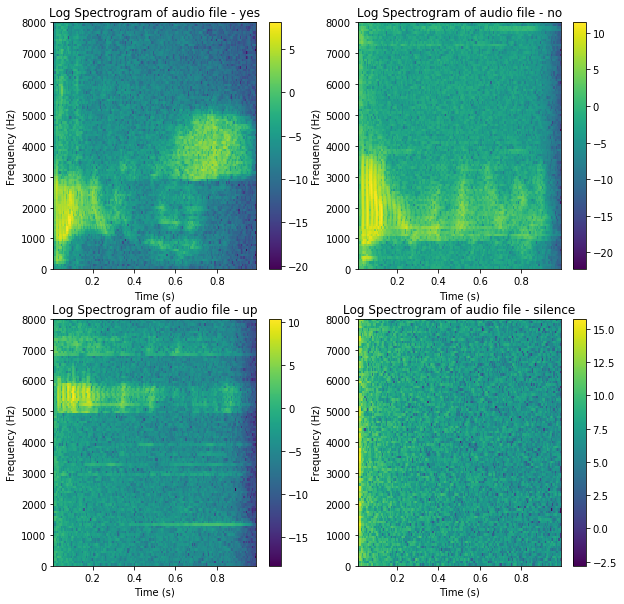

In [47]:
# function to compute the log spectrogram [1]
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

#list the files and the audio labels
audio_list = ["yes/f2a90886_nohash_0.wav","no/e32ff49d_nohash_1.wav","up/d8ee4734_nohash_1.wav","silence/noisy2_part57_pink_noise.wav"]
audio_labels = ["yes","no","up","silence"]

#plot the spectrograms

fig,ax = plt.subplots(2,2,figsize=(10,10))

for i, audio in enumerate(audio_list):
    plt.subplot(2,2,i+1)
    ax = plt.gca()
    ax.set_title("Log Spectrogram of audio file - " + audio_labels[i])
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    sample_rate, samples = wavfile.read("train/audio/" + audio)
    freqs, times, spec = log_specgram(audio=samples, sample_rate=16000)
    im = ax.imshow(spec, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    fig.colorbar(im, ax=ax)

* We can further investigate this by observing the spectrograms of 4 "yes" files and 4 "no" files.
* The shape of each voice command appears to be roughly the same but being shifted up and down the x-axis.
* This means that a CNN should be able to classify the word correctly as the CNN is resillient to translations of a pattern in an image.

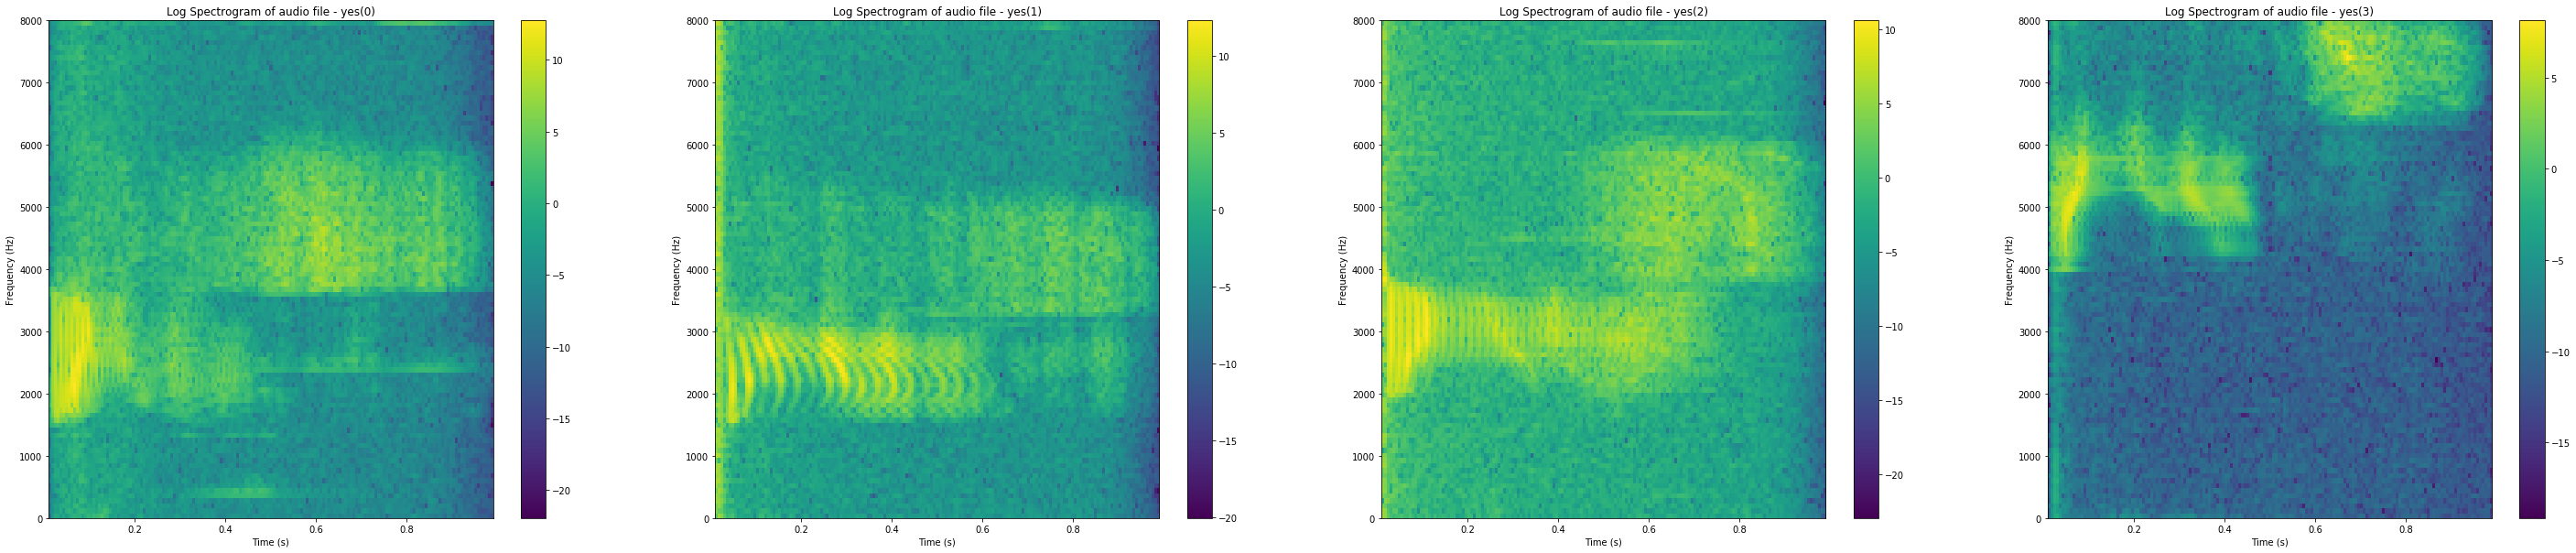

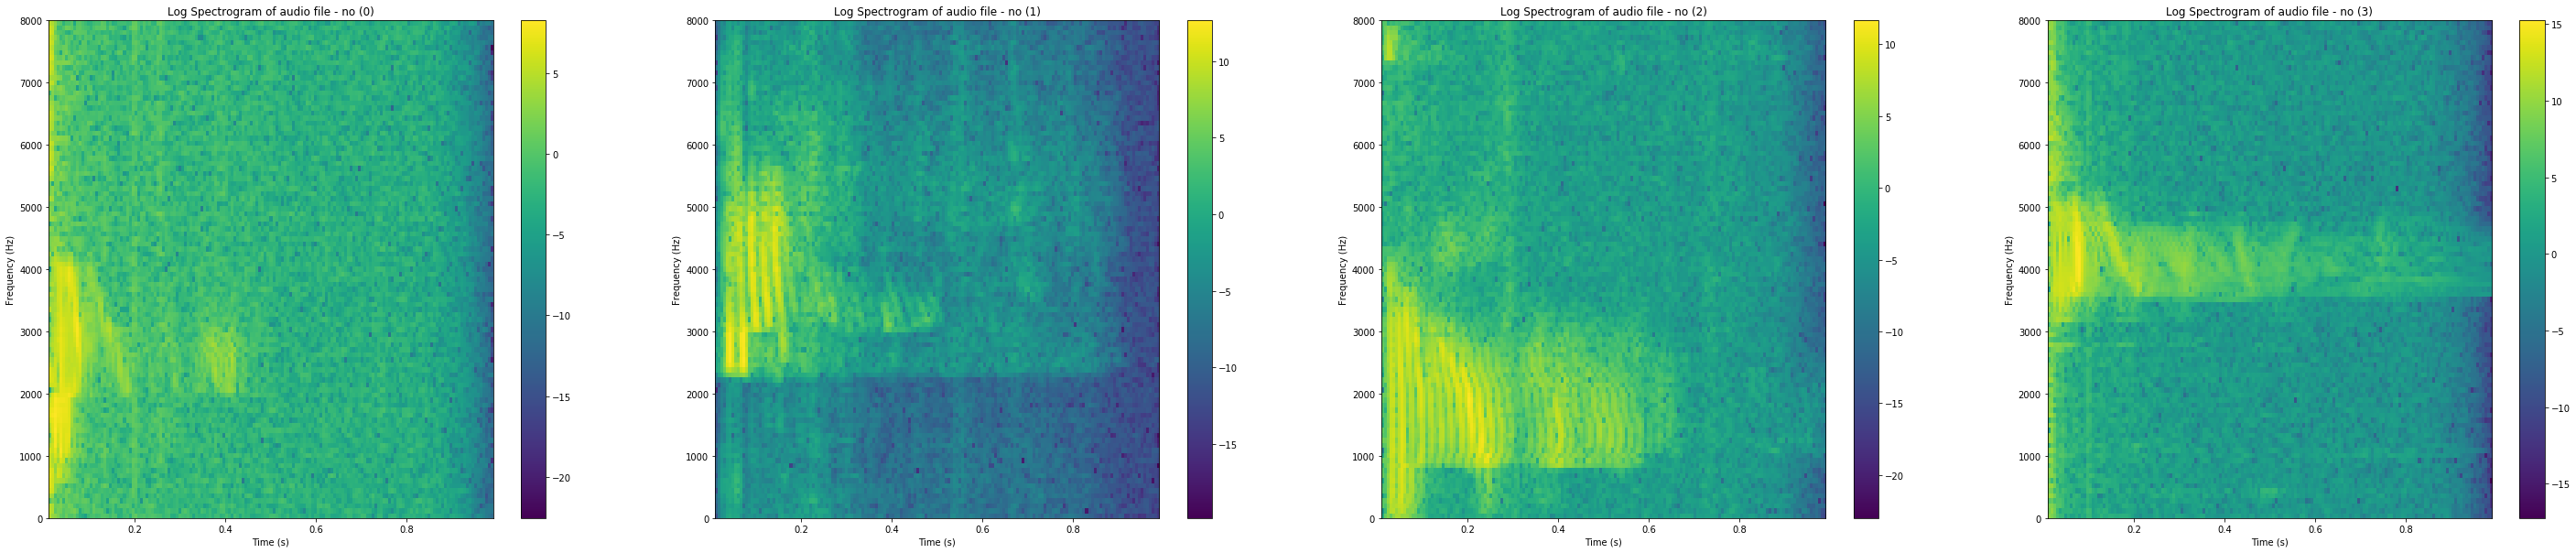

In [50]:
#load in the yes files and the no files

yes_files = ["yes/0bd689d7_nohash_0.wav","yes/a5d485dc_nohash_2.wav","yes/a60a09cf_nohash_1.wav","yes/e14a99a5_nohash_1.wav"]
no_files = ["no/0bde966a_nohash_2.wav","no/951cac20_nohash_1.wav","no/afb9e62e_nohash_1.wav","no/dc6e9c04_nohash_1.wav"]

fig,ax = plt.subplots(1,4,figsize=(50,10))

for i, audio in enumerate(yes_files):
    plt.subplot(1,4,i+1)
    ax = plt.gca()
    ax.set_title("Log Spectrogram of audio file - yes" +"("+str(i)+")")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    sample_rate, samples = wavfile.read("train/audio/" + audio)
    freqs, times, spec = log_specgram(audio=samples, sample_rate=16000)
    im = ax.imshow(spec, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    fig.colorbar(im, ax=ax)
    
fig,ax = plt.subplots(1,4,figsize=(50,10))

for i, audio in enumerate(no_files):
    plt.subplot(1,4,i+1)
    ax = plt.gca()
    ax.set_title("Log Spectrogram of audio file - no" +" ("+str(i)+")")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    sample_rate, samples = wavfile.read("train/audio/" + audio)
    freqs, times, spec = log_specgram(audio=samples, sample_rate=16000)
    im = ax.imshow(spec, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    fig.colorbar(im, ax=ax)